# Analyse du mot 'personne' dans les avis du CCNE   

Code avec : 
tirage d'une base totalement aléatoire filtrée avec les mots d'intérêt pour exploration et rédaction de la guideline d'annotation
export de cette base

embedding des mots choisis

tirage d'un set représentatif de phrases.

In [1]:
!pip install pdf2image pytesseract pyPDF2 tika reportlab openpyxl

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# The autoreload extension is already loaded. To reload it, use:
#%reload_ext autoreload
import sys
sys.path.append('./helpers')  # Add the src directory to the Python path

from database_creation import open_avis, join_metadata, corpus_to_sentences_with_context, filter_sentences_with_words, has_words
from display import interactive_sentence_display, generate_sentences_pdf

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\leopo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Base mise au niveau de la phrase, et exemples pour guideline d'annotation

In [3]:
# Step 1: Open Avis
# base_avis_ccne = open_avis(rescrap_texte=True)

#  75%|███████▌  | 108/144 [09:10<00:28,  1.25it/s]Xref table not zero-indexed. ID numbers for objects will be corrected.
#  86%|████████▌ | 124/144 [09:30<00:37,  1.88s/it]Xref table not zero-indexed. ID numbers for objects will be corrected.
# 100%|██████████| 144/144 [10:09<00:00,  4.23s/it]

In [4]:
# Step 1: Open Avis
base_avis_ccne = open_avis(rescrap_texte=False, use_acrobat_corrected_pdf=False)

# Step 2: Join Metadata
base_avis_ccne = join_metadata(base_avis_ccne)

In [5]:
# Step 3: Transform to Sentences with Context
base_sentences = corpus_to_sentences_with_context(base = base_avis_ccne)


              corpus_to_sentences_with_context :
              is  the number of sentences counted corresponding to the number of rows by 'num' ?
              True


In [6]:
# Step 4: Filter on sentences with 'personne' in it
base_filtered = filter_sentences_with_words(base_sentences,["personne","personnes",'humain','humains','humaine','humaines','individu','individus'])

# Exploration des phrases

In [7]:
# Step 5: Sample 100 sentences
exploration_samples = base_filtered.sample(100, random_state = 1968)
# le tirage original fut fait avec ["personne","personnes","humain","humains","humaine","humaines"]
# et surtout une fonction has_words qui regardait si la chaine "personne" était présente et donc "personnel" sortait positif.

In [8]:
# Step 6: Display samples
interactive_sentence_display(exploration_samples)

ToggleButtons(options=('Show Metadata', 'Hide Metadata'), value='Show Metadata')

Button(description='Previous', style=ButtonStyle())

Button(description='Next', style=ButtonStyle())

Output()

In [9]:
generate_sentences_pdf(exploration_samples, "../output/exploration/phrase_personne_humain.pdf")

# Présence lexicale et export

## Présence lexicale

In [10]:
synonyms = {
    'personne': ['personne', 'personnes'],
    'humain': ['humain', 'humaine', 'humains', 'humaines'],
    'individu': ['individu', 'individus'],
    'societe': ['société', 'sociétés', 'societé', 'societés', 'sociéte', 'sociétes', 'societe', 'societes'],
    'nature': ['nature','natures'],
    'environnement': ['environnement','environnements'],
    'gene':["génétique","génétiques","gène","gènes"]
    
}

print(f"Nombre de phrases total dans les avis : {len(base_sentences)}")

for key in synonyms.keys():
    has_specific_words = lambda x: has_words(x, words=synonyms[key])
    base_sentences[key] = base_sentences['sentence'].apply(has_specific_words)
    n = sum(base_sentences[key])
    print(f"Le nombre de phrases qui contient {synonyms[key]} est {n}")

Nombre de phrases total dans les avis : 54030
Le nombre de phrases qui contient ['personne', 'personnes'] est 5077
Le nombre de phrases qui contient ['humain', 'humaine', 'humains', 'humaines'] est 2476
Le nombre de phrases qui contient ['individu', 'individus'] est 654
Le nombre de phrases qui contient ['société', 'sociétés', 'societé', 'societés', 'sociéte', 'sociétes', 'societe', 'societes'] est 1390
Le nombre de phrases qui contient ['nature', 'natures'] est 635
Le nombre de phrases qui contient ['environnement', 'environnements'] est 332
Le nombre de phrases qui contient ['génétique', 'génétiques', 'gène', 'gènes'] est 2416


## Export unshuffled

In [13]:
base_sentences["citations_autres_avis"]

0              nan
1              nan
2              nan
3              nan
4              nan
           ...    
54025    140;covid
54026    140;covid
54027    140;covid
54028    140;covid
54029    140;covid
Name: citations_autres_avis, Length: 54030, dtype: object

In [14]:
base_sentences["citations_autres_avis"] = base_sentences["citations_autres_avis"].apply(str)
base_avis_ccne["citations_autres_avis"] = base_avis_ccne["citations_autres_avis"].apply(str)

In [15]:
base_sentences
base_sentences[['num', 'sentence_index', 'number_sentences', 'previous', 
                'sentence', 'next', 'personne', 'humain', 'individu', 
                'societe', 'nature', 'environnement', 'gene']].to_feather("../data/intermediate/big/base_sentences.feather")
base_avis_ccne.to_feather("../data/intermediate/base_avis.feather")

## Shuffled export

In [16]:
import pandas as pd
import numpy as np

shuffle_seed = 23021983 # CCNE décret de création

base_sentences["to_be_included"] = base_sentences["personne"] + base_sentences["humain"] + base_sentences["individu"]

base_filtered = base_sentences[base_sentences["to_be_included"]].copy()

# Assuming 'df' is your DataFrame and it has columns 'num' and 'sentence_index'
base_filtered['num_formatted'] = base_filtered['num'].apply(lambda x: f'{x:03}')
base_filtered['sentence_index_formatted'] = base_filtered['sentence_index'].apply(lambda x: f'{x:04}')
base_filtered['sentence_id'] = base_filtered['num_formatted'] + base_filtered['sentence_index_formatted']

base_filtered["sentence_text"] = base_filtered["previous"] + " " + base_filtered["sentence"] + " " + base_filtered["next"]

base_filtered = base_filtered[["sentence_id","sentence_text","sentence",
                               "personne","humain","individu",
                               "Titre","Date","president",
                               "rapporteurs","membres_gt","theme",
                               'saisine','divergence','CNPEN','tableaux et graphiques',
                               "nb_mots","number_sentences","nb_pages",
                               "sentence_index","num"]].copy()

np.random.seed(shuffle_seed)  # For reproducibility, but still non-deterministic for your use case

# Shuffle the DataFrame
base_shuffled = base_filtered.sample(frac=1, random_state=shuffle_seed).reset_index(drop=True)

def calculate_distances(data, category):
    # Find indices where category changes from 0 to 1
    change_indices = data.index[data[category].diff() == 1].tolist()
    # Calculate distances between consecutive changes
    distances = np.diff(change_indices)
    return distances

# Calculate distances, mean, and variance for each category
controls_stats = {}
for category in ['personne', 'humain', 'individu']:
    distances = calculate_distances(base_shuffled, category)
    controls_stats[category] = {
        'mean_distance': np.mean(distances) if len(distances) > 0 else np.nan,
        'variance_distance': np.var(distances, ddof=1) if len(distances) > 1 else np.nan  # ddof=1 for sample variance
    }

controls_stats




{'personne': {'mean_distance': 2.204209328782708,
  'variance_distance': 3.3329666292842153},
 'humain': {'mean_distance': 2.2424768518518516,
  'variance_distance': 3.922085209304819},
 'individu': {'mean_distance': 6.574341546304163,
  'variance_distance': 94.19366081181836}}

In [17]:
# Count rows containing a semicolon
semicolon_count = base_shuffled['sentence_text'].str.contains(';').sum()
print(f"Number of rows containing a semicolon: {semicolon_count}")

doublequotes_count = base_shuffled['sentence_text'].str.contains('"').sum()
print(f"Number of rows containing a semicolon: {doublequotes_count}")


Number of rows containing a semicolon: 1056
Number of rows containing a semicolon: 737


In [18]:
base_shuffled.to_csv('../data/intermediate/base_shuffled.csv', sep=';', index=False, quotechar='"')
base_shuffled.to_pickle("../data/intermediate/base_shuffled.pkl")

# Embedding

In [19]:
# Define the list of words
word_list = ["personne", "humain", "individu","nature","société","enfant","femme","génétique","cellule","données","santé","éthique","recherche","loi","droit","risque","malade"]

In this code snippet, we are performing various operations on textual data using the BERT (Bidirectional Encoder Representations from Transformers) model, particularly focusing on generating embeddings for a list of French words. The BERT model used here is specifically trained for French language understanding tasks, known as CamemBERT.

First, we load the pre-trained CamemBERT model and tokenizer from the Hugging Face library. The tokenizer is responsible for tokenizing the input text into individual tokens recognizable by the model, while the model itself is capable of generating contextualized embeddings for these tokens.

Next, we define a list of French words for which we want to generate embeddings. These words are tokenized using the CamemBERT tokenizer, converting them into token IDs recognizable by the model.

We then feed these tokenized inputs into the CamemBERT model. Specifically, we utilize the model to obtain the hidden states of the last layer. These hidden states contain rich contextual information about each token in the input.

From the hidden states of the last layer, we calculate the mean embedding for each word by averaging the embeddings of all tokens corresponding to that word. This mean pooling operation allows us to obtain a single fixed-size embedding vector for each word.

Furthermore, we compute pairwise cosine similarity/distance between the embeddings of the words, providing insight into the semantic similarity or dissimilarity between the words.

Additionally, we perform Principal Component Analysis (PCA) on the embeddings to visualize them in a lower-dimensional space. PCA is a dimensionality reduction technique that helps capture the most significant variations in the data, allowing us to visualize the embeddings in a more interpretable 2D space.

Overall, the type of embedding we are generating in this process is contextualized word embeddings using CamemBERT, specifically by extracting the hidden states from the last layer of the model and subsequently averaging them to obtain word-level embeddings. These embeddings capture the contextual information of each word within the given text data, enabling downstream NLP tasks such as semantic similarity comparison, clustering, or classification.

## Word2Vec

In [20]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec

type_embedding =  "Word2Vec"

# Tokenize sentences
tokenized_sentences = [sentence.lower().split() for sentence in base_sentences["sentence"]]

# Train Word2Vec model
model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, sg=1)


# Get embeddings for each word
embeddings = [model.wv[word] for word in word_list]


## Affichage

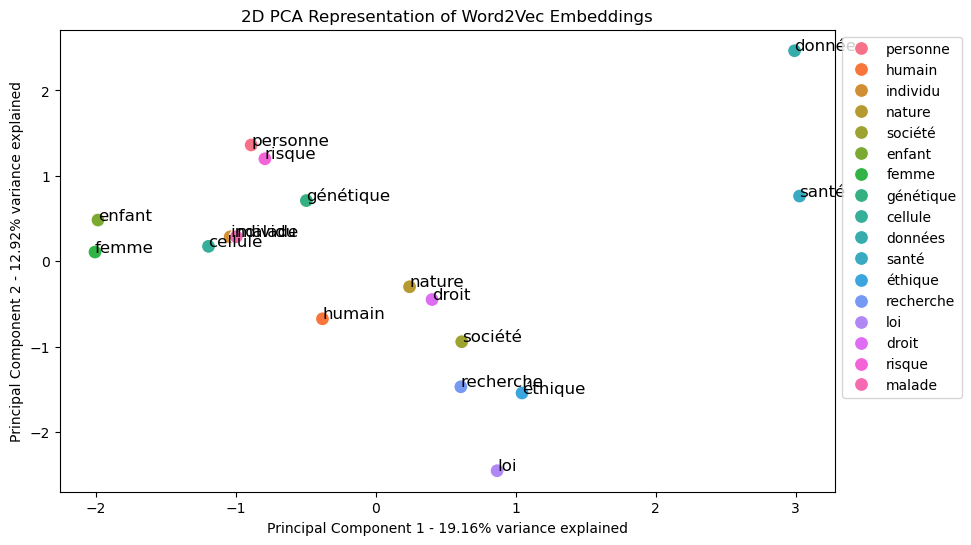

Cosine similarity Matrix:


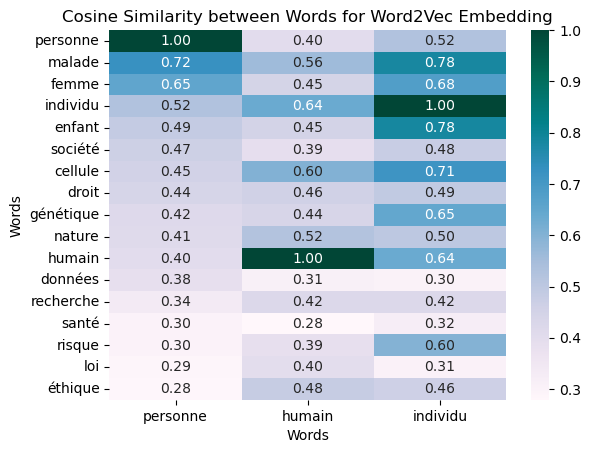

Euclidian distance Matrix:


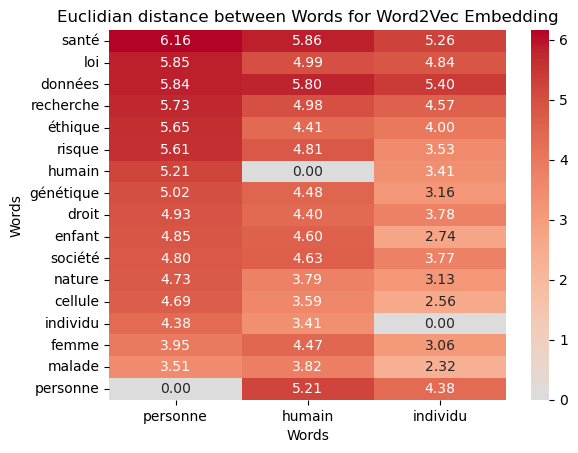

In [21]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_result = pca.fit_transform(embeddings)

# Plot PCA result using Seaborn
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
df_pca['Word'] = word_list

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Word', s=100)
for i in range(len(word_list)):
    plt.text(df_pca['PC1'][i], df_pca['PC2'][i], df_pca['Word'][i], fontsize=12)
plt.xlabel('Principal Component 1 - {:.2f}% variance explained'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('Principal Component 2 - {:.2f}% variance explained'.format(pca.explained_variance_ratio_[1] * 100))
plt.title(f'2D PCA Representation of {type_embedding} Embeddings')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

# Compute pairwise cosine similarity/distance
distance_matrix = np.zeros((len(word_list), len(word_list)))
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        similarity = cosine_similarity([embeddings[i]], [embeddings[j]])
        distance_matrix[i][j] = similarity[0][0]  # Extracting the scalar value

# Print distance matrix with proper representation
print("Cosine similarity Matrix:")
df_distance_matrix = pd.DataFrame(distance_matrix, index=word_list, columns=word_list).sort_values(by = "personne", ascending=False)
sns.heatmap(df_distance_matrix[["personne","humain","individu"]], annot=True, cmap='PuBuGn', fmt=".2f")
plt.xlabel('Words')
plt.ylabel('Words')
plt.title(f'Cosine Similarity between Words for {type_embedding} Embedding')
plt.show()

# Compute pairwise cosine similarity/distance
distance_matrix = np.zeros((len(word_list), len(word_list)))
for i in range(len(embeddings)):
    for j in range(len(embeddings)):
        similarity = euclidean_distances([embeddings[i]], [embeddings[j]])
        distance_matrix[i][j] = similarity[0][0]  # Extracting the scalar value

print("Euclidian distance Matrix:")
df_distance_matrix = pd.DataFrame(distance_matrix, index=word_list, columns=word_list).sort_values(by = "personne", ascending=False)
sns.heatmap(df_distance_matrix[["personne","humain","individu"]], annot=True, cmap='coolwarm', fmt=".2f",center=0)
plt.xlabel('Words')
plt.ylabel('Words')
plt.title(f'Euclidian distance between Words for {type_embedding} Embedding')
plt.show()

# Exemple de pipeline pour classification avec embedding

In [22]:
import numpy as np
from sentence_transformers import SentenceTransformer
import fasttext
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Chargez les modèles FastText et SBERT
ft_model = fasttext.load_model('cc.en.300.bin')
sbert_model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(text):
    # Générer l'embedding SBERT pour le document entier
    sbert_embedding = sbert_model.encode(text)
    
    # Générer les embeddings FastText pour chaque mot et les agréger
    words = text.split()
    ft_embeddings = np.array([ft_model.get_word_vector(word) for word in words])
    ft_embedding_avg = np.mean(ft_embeddings, axis=0)
    
    # Combiner les embeddings (exemple : concaténation)
    combined_embedding = np.concatenate([ft_embedding_avg, sbert_embedding])
    
    return combined_embedding

# Exemple d'application avec des données fictives
texts = ["Votre texte ici.", "Un autre exemple de texte."]
embeddings = np.array([generate_embeddings(text) for text in texts])

# Labels fictifs pour l'exemple
labels = np.array([0, 1])

# Entraînement du modèle
X_train, X_test, y_train, y_test = train_test_split(embeddings, labels, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)

# Évaluation
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")


ModuleNotFoundError: No module named 'sentence_transformers'

# Comparaison tesseract OCR et acrobat OCR



In [23]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
# The autoreload extension is already loaded. To reload it, use:
#%reload_ext autoreload
import sys
sys.path.append('./helpers')  # Add the src directory to the Python path

from database_creation import open_avis, join_metadata, corpus_to_sentences_with_context, filter_sentences_with_words, has_words
from display import interactive_sentence_display, generate_sentences_pdf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# Step 1: Open Avis
base_avis_ccne_tesseract = open_avis(rescrap_texte=False, use_acrobat_corrected_pdf = False)

# Step 2: Join Metadata
base_avis_ccne_tesseract = join_metadata(base_avis_ccne_tesseract)

base_sentences_tesseract = corpus_to_sentences_with_context(base = base_avis_ccne_tesseract)

base_tesseract = filter_sentences_with_words(base_sentences_tesseract,["personne","personnes",'humain','humains','humaine','humaines','individu','individus'])


              corpus_to_sentences_with_context :
              is  the number of sentences counted corresponding to the number of rows by 'num' ?
              True


In [25]:
# Step 1: Open Avis
base_avis_ccne_acrobat = open_avis(rescrap_texte=False, use_acrobat_corrected_pdf = True)

# Step 2: Join Metadata
base_avis_ccne_acrobat = join_metadata(base_avis_ccne_acrobat)

base_sentences_acrobat = corpus_to_sentences_with_context(base = base_avis_ccne_acrobat)

base_acrobat = filter_sentences_with_words(base_sentences_acrobat,["personne","personnes",'humain','humains','humaine','humaines','individu','individus'])


              corpus_to_sentences_with_context :
              is  the number of sentences counted corresponding to the number of rows by 'num' ?
              True


In [26]:
bugged_pdf = [69, 70, 71, 72, 76, 77, 78, 79, 80, 83, 84, 86, 89]

In [27]:
base_tesseract = base_tesseract[base_tesseract["num"].isin(bugged_pdf)]

In [28]:
base_acrobat = base_acrobat[base_acrobat["num"].isin(bugged_pdf)]

In [29]:
sentence_counts_by_avis_tesseract = base_tesseract["num"].value_counts()
sentence_counts_by_avis_tesseract

num
77    154
79     67
70     54
71     51
78     41
76     35
84     28
86     28
72     26
83     24
89     10
80      3
69      1
Name: count, dtype: int64

In [30]:
sentence_counts_by_avis_acrobat = base_acrobat["num"].value_counts()
sentence_counts_by_avis_acrobat

num
77    153
79     70
70     54
71     51
78     41
76     35
84     28
86     28
72     26
83     24
89     10
80      3
69      1
Name: count, dtype: int64

In [31]:
# Filtered list comprehension to include only items where the values are different
avis_avec_differences_nb_phrases = [avis for avis in bugged_pdf if sentence_counts_by_avis_tesseract[avis] != sentence_counts_by_avis_acrobat[avis]]

In [32]:
base_acrobat_avis_diff_sentences = base_acrobat[base_acrobat["num"].isin(avis_avec_differences_nb_phrases)][["num","sentence_index","sentence"]]

In [33]:
import pandas as pd
pd.set_option('display.max_colwidth', 1000)
base_acrobat_avis_diff_sentences

,num,sentence_index,sentence
19205,77,1,": S. BELOUCIF \nG. BREART \nG. ORTH (responsable) COMIT É CONSULTATIF NATIONAL D 'ÉTHIQUE POUR LES SCIENCES DE LA VIE ET DE LA SANT É \n2 Avis \nProblèmes éthiques posés par les collections de matériel biologique et \nles données d'information associées : « biobanques » « biothèques » \nLes activités de collection et de traitement des échantillons biologiques \nd'origine humaine et des données d'information en résultant, plus \nparticulièrement du fait de la recherche génétique suscitent des \ninterrogations éthiques majeures."
19212,77,8,Il \nserait regrettable que la réticence des personnes à participer aux collections \nle doive exclusivement à l'insuffisance de leur niveau de compréhension.
19213,77,9,"Pour autant, rien de garantit à l'avance qu'une bonne diffusion de la \nconnaissance dans l'espace public entraînera une adhésion unanime, car \nnul n'ignore que la science n'est pas la seule institution sociale à s'intéresser \naux pratiques du recueil de données d'information relatives aux \ncomposantes génétiques des personnes."
19215,77,11,"Aussi, l'objectif du présent avis serat-il d'apporter certains \néléments de réponse à une question bien précise : à quelles conditions les \nactivités de collection et de traitement d'échantillons issus du corps humain \npeuventelles se dérouler dans un climat de confiance ?"
19220,77,16,"Ces activités évoluent actuellement dans \nun réseau d'obligations législatives et réglementaires ; elles ne sont pas \nsoumises aux libres lois de l'entreprise ; les pôles d'une construction existent \navec les règles d'indisponibilité et de noncommercialisation, régissant dans \nle code civil et le code de la santé publique, la collecte d'éléments du corps \nhumain ; le régime de protection des fichiers informatisés placé sous le \ncontrôle de la CNIL et le réseau des centres de ressources biologiques \nrécemment monté par le ministère de la recherche encadrent les projets et \nconstitutions de collections."
...,...,...,...
20712,79,388,"C'est cette contradiction même qui \n \n \n49 Le contrôle éthique de la recherche comportementale chez l'homme, Rapport par le Groupe ""Sciences du comportement humain"" du Copé, Octobre 1998 \n50 CCNE: Avis n° 38 (14 octobre 1993) sur l'éthique de la recherche dans les sciences du comportement humain."
20713,79,389,Disponible sur: http://www.ccneethique.fr \n19 suppose que le chercheur soit toujours conscient de ses responsabilités scientifiques mais aussi humaines.
20715,79,391,"De l'autre, l'accès de la personne dans l'incapacité de donner son consentement à une recherche médicale ayant une finalité cognitive ou thérapeutique ne doit pas aller de soi sans protection renforcée de la personne."
20717,79,393,Comment protéger la personne de l'aventurisme et d'une science sans limites ?


In [34]:
base_tesseract_avis_diff_sentences = base_tesseract[base_tesseract["num"].isin(avis_avec_differences_nb_phrases)][["num","sentence_index","sentence"]]

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_measure(str1, str2):
    vectorizer = CountVectorizer().fit_transform([str1, str2])
    vectors = vectorizer.toarray()
    return cosine_similarity(vectors)[0,1]
